# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import numpy as np

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL

/Users/skim0119/anaconda3/envs/ctf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [119]:
gamma = 0.97

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0.0
    for t in reversed(range(r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def discount_rewards_multiagent(r, n_agents):
    discounted_r = np.reshape(r,(-1,n_agents)) # Reshape the r in vertical matrix with n_agents columns
    for idx in range(n_agents):
        column = discounted_r[:,idx]
        discounted_r[:,idx] = discount_rewards(column);
    return np.reshape(discounted_r,(-1))

## Environment Setting

In [122]:
env = gym.make("cap-v0") # initialize the environment

policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)

## Network Setting

In [123]:
class agent():
    def __init__(self, lr, in_size,action_size):
        #These lines established the feed-forward part of the network. The agent takes a state and produces an action.
        self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
        conv1 = slim.conv2d(self.state_input, 48, [3,3],# activation_fn=tf.nn.relu,
                            scope='conv1')
        conv2 = slim.conv2d(conv1, 96, [2,2],# activation_fn=tf.nn.relu,
                            scope='conv2')
        flat  = tf.reshape(conv2, [-1, 7*7*96])#slim.flatten(conv2)
        
        dense = slim.fully_connected(flat, action_size,
                                            #activation_fn=tf.nn.relu,
                                            biases_initializer=None)
        self.output = tf.nn.softmax(dense, name='action')
        #self.chosen_action = tf.argmax(self.output,1, name='action')

        #The next six lines establish the training proceedure. We feed the reward and chosen action into the network
        #to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
    

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

In [124]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr=1e-4,in_size=[None,7,7,6],action_size=5) #Load the agent.
global_step = tf.Variable(0, trainable=False, name='global_step') # global step
increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

/Users/skim0119/anaconda3/envs/ctf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Hyperparameters

In [125]:
total_episodes = 100000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5
save_frequency = 100

exploration_final = 0.01
exploration = 1.0
exploration_decay = 0.99

## Session

In [126]:
# Launch the session
sess = tf.Session()

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [127]:
'''
Try to parametrize the size of vision
UNKNOWN = -1
TEAM1_BACKGROUND = 0
TEAM2_BACKGROUND = 1
TEAM1_UGV = 2
TEAM1_UAV = 3
TEAM2_UGV = 4
TEAM2_UAV = 5
TEAM1_FLAG = 6
TEAM2_FLAG = 7
OBSTACLE = 8
DEAD = 9
SELECTED = 10
COMPLETED = 11
'''
def one_hot_encoder(state, agents):
    ret = np.zeros((len(agents),7,7,6))
    # team 1 : (1), team 2 : (-1)
    map_channel = {-1:0, 0:1, 1:1, 2:2, 4:2, 3:3, 5:3, 6:4, 7:4, 8:5, 9:0}
    map_color   = {-1:0, 0:1, 2:1, 3:1, 6:1, 1:-1, 4:-1, 5:-1, 7:-1, 8:1, 9:0}
    #reorder = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 8:6, 9:7} # CHANGE
    
    # Expand the observation with 3-thickness wall
    # - in order to avoid dealing with the boundary
    sx, sy = state.shape
    _state = np.ones((sx+8, sy+8)) * 8 # 8 for obstacle
    _state[4:4+sx, 4:4+sy] = state
    state = _state

    for idx,agent in enumerate(agents):
        # Initialize Variables
        x, y = agent.get_loc()
        x += 4
        y += 4
        vision = state[x-3:x+4, y-3:y+4] # limited view for the agent (5x5)
        for i in range(len(vision)):
            for j in range(len(vision[0])):
                if vision[i][j] != -1:
                    channel = map_channel[vision[i][j]]
                    ret[idx][i][j][channel] = map_color[vision[i][j]]
    return ret

## Training

In [ ]:
i = 0

total_reward = []
total_lenght = []

reward_table = []

action_space = 5
n_agent = len(env.get_team_blue)

gradBuffer = sess.run(tf.trainable_variables())
for ix,grad in enumerate(gradBuffer):
    gradBuffer[ix] = grad * 0

progbar = tf.keras.utils.Progbar(total_episodes,width=5)
while i < total_episodes:
    progbar.update(i) # update progress bar
    s = env.reset(map_size=20, render_mode='env', policy_red=policy_red)
    prev_reward=0
    running_reward = 0
    ep_history = []
    for j in range(max_ep):
        obs = one_hot_encoder(s, env.get_team_blue).tolist() # observation
        if exploration > np.random.random(): # explorate
            a = np.random.randint(action_space, size=len(env.get_team_blue)).tolist()
        else:
            obs = one_hot_encoder(s, env.get_team_blue).tolist()
            a = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
            #Probabilistically pick an action given our network outputs.
            a = [np.random.choice(action_space, p=a[x]/sum(a[x])) for x in range(n_agent)] # divide by sum : normalize
        s1,r_a,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
        
        # Rendering
        #env.render(mode="fast")
        #time.sleep(0.05)
        
        r = r_a-prev_reward # immediate reward
        prev_reward = r_a
        
        for state, act in zip(obs, a):
            ep_history.append([state,act,r,s1])
        s = s1
        running_reward += r
        if d == True or r > 0:
            #Update the network.
            ep_history = np.array(ep_history)
            ep_history[:,2] = discount_rewards_multiagent(ep_history[:,2], len(env.get_team_blue))
            #ep_history[:,2] = discount_rewards(ep_history[:,2], len(env.get_team_blue))
            feed_dict={myAgent.reward_holder:ep_history[:,2],
                       myAgent.action_holder:ep_history[:,1],
                       myAgent.state_input:np.stack(ep_history[:,0])}
            grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
            for idx,grad in enumerate(grads):
                gradBuffer[idx] += grad

            if i % update_frequency == 0 and i != 0:
                feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                for ix,grad in enumerate(gradBuffer):
                    gradBuffer[ix] = grad * 0

            total_reward.append(running_reward)
            total_lenght.append(j)
            break

    exploration = max(exploration_decay*exploration, exploration_final)
        #Update our running tally of scores.
    if i % save_frequency == 0:
        print(' Last 100 Average reward : ', np.mean(total_reward[-100:]), exploration)
        reward_table.append(np.mean(total_reward[-100:]))
        if len(reward_table) > 100:
            reward_table.pop(0)
        saver.save(sess, './model/ctf_policy.ckpt', global_step=global_step)
        print("save: ", sess.run(global_step))

    i += 1
    sess.run(increment_global_step_op)

     0/100000 [.....] - ETA: 0s

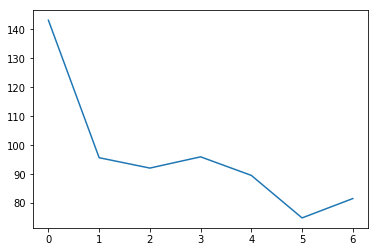

In [13]:
plt.plot(reward_table)

In [12]:
obs = one_hot_encoder(s, env.get_team_blue)
print(sess.run(myAgent.output, feed_dict={myAgent.state_input:obs}))

[[0.2 0.2 0.2 0.2 0.2]]


In [14]:
for i in range(len(env.get_team_blue)):
    sub_obs = np.stack([obs[i,:,:,:]])
    print(sess.run(myAgent.output, feed_dict={myAgent.state_input:sub_obs}))

[[0.2 0.2 0.2 0.2 0.2]]


In [16]:
len(env.get_team_blue)

1